In [27]:
import json
import pandas as pd
import numpy as np
import os
import importlib
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#reload del modulo caricato la prima volta, per prendere la versione aggiornata
import utils.type_effects as type_effects
importlib.reload(type_effects)
from utils.type_effects import TYPE_EFFECTIVENESS, type_advantage
import utils.model as model
importlib.reload(model)
from utils.model import run_pca, show_graph

In [28]:
# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
train_data = []

# Read the file line by line
print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            # json.loads() parses one line (one JSON object) into a Python dictionary
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.")

    # Let's inspect the first battle to see its structure
    print("\n--- Structure of the first train battle: ---")
    if train_data:
        first_battle = train_data[0]
        
        # To keep the output clean, we can create a copy and truncate the timeline
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', [])[:2] # Show first 2 turns
        
        # Use json.dumps for pretty-printing the dictionary
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input\fds-pokemon-battles-prediction-2025\train.jsonl'...
Successfully loaded 10000 battles.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",

In [29]:
def create_simple_features(data: list[dict]) -> pd.DataFrame:
    feature_list = []
    p1_bad_status_advantage = []
    status_change_diff = []
    for battle in tqdm(data, desc="Extracting features"):
        
        features = {}
        
        # --- Player 1 Team Features ---
        p1_mean_hp = p1_mean_spe = p1_mean_atk = p1_mean_def = p1_mean_sp = 0.0
        p1_lead_hp = p1_lead_spe = p1_lead_atk = p1_lead_def = p1_lead_sp = 0.0

        p1_team = battle.get('p1_team_details', [])
        if p1_team:

            p1_mean_hp = np.mean([p.get('base_hp', 0) for p in p1_team])
            p1_mean_spe = np.mean([p.get('base_spe', 0) for p in p1_team])
            p1_mean_atk = np.mean([p.get('base_atk', 0) for p in p1_team])
            p1_mean_def = np.mean([p.get('base_def', 0) for p in p1_team])
            p1_mean_sp = np.mean([p.get('base_spd', 0) for p in p1_team])

            features['p1_mean_hp'] = p1_mean_hp
            features['p1_mean_spe'] = p1_mean_spe
            features['p1_mean_atk'] = p1_mean_atk
            features['p1_mean_def'] = p1_mean_def
            features['p1_mean_sp'] = p1_mean_sp

            #PER UN CONFRONTO EQUO UTILIZZIAMO SOLO DATI DEL LEADER ANCHE NELLA SQUADRA 1 PER LE DIFFERENZE            
            p1_lead_hp =  p1_team[0].get('base_hp', 0)      
            p1_lead_spe = p1_team[0].get('base_spe', 0)  
            p1_lead_atk = p1_team[0].get('base_atk', 0)  
            p1_lead_def = p1_team[0].get('base_def', 0)  
            p1_lead_sp =  p1_team[0].get('base_spd', 0)  



        # --- Player 2 Lead Features ---
        p2_hp = p2_spe = p2_atk = p2_def = p2_sp= 0.0
        p2_lead = battle.get('p2_lead_details')
        if p2_lead:
            # Player 2's lead Pokémon's stats
            p2_hp = p2_lead.get('base_hp', 0)
            p2_spe = p2_lead.get('base_spe', 0)
            p2_atk = p2_lead.get('base_atk', 0)
            p2_def = p2_lead.get('base_def', 0)
            p2_sp = p2_lead.get('base_spd', 0)
            


        # I ADD THE DIFFS/DELTAS
        features['diff_hp']  = p1_lead_hp  - p2_hp
        features['diff_spe'] = p1_lead_spe - p2_spe
        features['diff_atk'] = p1_lead_atk - p2_atk
        features['diff_def'] = p1_lead_def - p2_def
        features['diff_sp'] =  p1_lead_sp - p2_sp
        


        #DYNAMIC INFO
        #Chi mantiene più HP medi e conduce più turni,  nella maggior parte dei casi vince anche se la battaglia non è ancora finita
        timeline = battle.get('battle_timeline', [])
        if timeline:
            #SALUTE
            p1_hp = [t['p1_pokemon_state']['hp_pct'] for t in timeline if t.get('p1_pokemon_state')]
            p2_hp = [t['p2_pokemon_state']['hp_pct'] for t in timeline if t.get('p2_pokemon_state')]
            #salute media dei pokemon del primo giocatore
            #features['p1_mean_hp_pct'] = np.mean(p1_hp)
            #salute media dei pokemon del secondo giocatore ATTENZIONE FEATURE BUONE CORRELATE CON hp_diff_mean 75%,VALUTAZIONE DELL'EEFFETTO SU BASE SINGOLA (CON HP DIFF)
            #features['p2_mean_hp_pct'] = np.mean(p2_hp)
            #vantaggio medio in salute (media della differenza tra la salute dei pokemon del primo giocatore e quella dei pokemon del secondo giocatore)
            features['hp_diff_mean'] = np.mean(np.array(p1_hp) - np.array(p2_hp))
            #percentuale di tempo in vantaggio (ovvero media dei booleani che indicano il vantaggio => proporzione del vantaggio)
            features['p1_hp_advantage_mean'] = np.mean(np.array(p1_hp) > np.array(p2_hp))#GRAN BELLA OPZIONE DI CLASSIFICAZIONE POSSIBILE APPLICAZIONE DI EFFETTI DI ETEROGENEITA



            #SUM OF FINAL HP PERCENTAGE OF EACH PLAYER
            p1_hp_final ={}
            p2_hp_final ={}
            for t in timeline:
                if t.get('p1_pokemon_state'):
                    p1_hp_final[t['p1_pokemon_state']['name']]=t['p1_pokemon_state']['hp_pct']
                if t.get('p2_pokemon_state'):
                    p2_hp_final[t['p2_pokemon_state']['name']]=t['p2_pokemon_state']['hp_pct']
            #print(p1_hp_final)
            #numero di pockemon usati dal giocatore nei primi 30 turni
            features['p1_n_pokemon_use'] =len(p1_hp_final.keys())
            features['p2_n_pokemon_use'] =len(p2_hp_final.keys())
            #differenza nello schieramento pockemon dopo 30 turni
            features['diff_final_schieramento']=features['p1_n_pokemon_use']-features['p2_n_pokemon_use']
            #DOVREBBERO ESSERE BOMBA VITA DELLE DUE SQUADRE DOPO I 30 TURNI
            features['p1_pct_final_hp'] =np.sum(list(p1_hp_final.values()))+(6-len(p1_hp_final.keys()))
            features['p2_pct_final_hp'] =np.sum(list(p2_hp_final.values()))+(6-len(p1_hp_final.keys()))
            #SAREBBE CLAMOROSO NORMALIZZARLA ANCHE IN BASE ALLA DIFFERENZA DI VITA ASSOLUTA DEI POCKEMON LEADER DEI 2 PLAYER
            features['diff_final_hp']=features['p1_pct_final_hp']-features['p2_pct_final_hp'] 



            #vedo anche come la salute media evolve nel tempo
            phases = 3 #early, mid, late game
            nr_turns = 30 #numero turni
            slice_idx = nr_turns // phases #slice index must be integer
            #print("slice_idx: ",slice_idx, "len p1_hp: ",len(p1_hp))
            features['early_hp_mean_diff'] = np.mean(np.array(p1_hp[:slice_idx]) - np.array(p2_hp[:slice_idx]))
            features['late_hp_mean_diff'] = np.mean(np.array(p1_hp[-slice_idx:]) - np.array(p2_hp[-slice_idx:]))
            #features['phases_hp_mean_diff'] = features['late_hp_mean_diff'] - features['early_hp_mean_diff']
            #77.94% (+/- 0.35%) => 77.94% (+/- 0.41%)
            hp_delta = np.array(p1_hp) - np.array(p2_hp)
            features['hp_delta_trend'] = np.polyfit(range(len(hp_delta)), hp_delta, 1)[0]
            
            #fluttuazioni negli hp (andamento della partita: stabile o molto caotica)
            #77.94% (+/- 0.41%) => 79.09% (+/- 1.02%)
            features['p1_hp_std'] = np.std(p1_hp)
            features['p2_hp_std'] = np.std(p2_hp)
            features['hp_delta_std'] = np.std(hp_delta)

            
            ##STATUS (default nostatus, gli altri sono considerati negativi - i boost sono positivi)
            p1_status = [t['p1_pokemon_state'].get('status', 'nostatus') for t in timeline if t.get('p1_pokemon_state')]
            p2_status = [t['p2_pokemon_state'].get('status', 'nostatus') for t in timeline if t.get('p2_pokemon_state')]
            total_status = set(p1_status + p2_status)
            no_effect_status = {'nostatus', 'noeffect'}
            negative_status = {s for s in total_status if s not in no_effect_status}
            #mean of negative status
            p1_negative_status_mean = np.mean([s in negative_status for s in p1_status])
            p2_negative_status_mean = np.mean([s in negative_status for s in p2_status])
            #status advantage if p1 applied more status to p2 (differenza delle medie dei negativi)
            features['p1_bad_status_advantage'] = p2_negative_status_mean-p1_negative_status_mean
            p1_bad_status_advantage.append(features['p1_bad_status_advantage'])
            #how many times status changed? 
            # we have to check that first array shifted by 1 is 
            # different from the same array excluding the last element 
            # (so basically checking if status change in time)
            #somma il nr di volte in cui lo stato cambia, vedi se collineare
            p1_status_change = np.sum(np.array(p1_status[1:]) != np.array(p1_status[:-1]))
            p2_status_change = np.sum(np.array(p2_status[1:]) != np.array(p2_status[:-1]))
            #features['p1_status_change'] = p1_status_change
            #features['p2_status_change'] = p2_status_change
            features['status_change_diff'] = p1_status_change - p2_status_change
            status_change_diff.append(features['status_change_diff'])
            
            #QUANTO IL TEAM è BILANCIATO (TIPI E VELOCITA)
            #79.09% (+/- 1.02%) => 79.29% (+/- 0.92%)
            p1_types = [t for p in p1_team for t in p.get('types', []) if t != 'notype']
            features['p1_type_diversity'] = len(set(p1_types))

            MEDIUM_SPEED_THRESHOLD = 90 #medium-speed pokemon
            HIGH_SPEED_THRESHOLD = 100 #fast pokemon
            speeds = np.array([p.get('base_spe', 0) for p in p1_team])
            features['p1_avg_speed_stat_battaglia'] = np.mean(np.array(speeds) > MEDIUM_SPEED_THRESHOLD)
            features['p1_avg_high_speed_stat_battaglia'] = np.mean(np.array(speeds) > HIGH_SPEED_THRESHOLD)


            #COMBINAZIONI DI FEATURE
            #combino vantaggio negli hp con l'avere pochi status negativi
            #79.09% (+/- 1.02%) => 79.13% (+/- 1.06%)
            #features['hp_advantage_no_negative_status'] = features['hp_delta_trend'] * (1 - p1_negative_status_mean)
            #LA FEATURE è BELLA MA SUPER CORRELATA CON hp_delta_trend 95%
            #per il momento semplifico cosi capiamo poi è facile aggiungere

        # We also need the ID and the target variable (if it exists)
        features['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            features['player_won'] = int(battle['player_won'])
            
        feature_list.append(features)

    return pd.DataFrame(feature_list).fillna(0)




# Create feature DataFrames for both training and test sets
print("Processing training data...")
train_df = create_simple_features(train_data)

print("\nProcessing test data...")
test_data = []
with open(test_file_path, 'r') as f:
    for line in f:
        test_data.append(json.loads(line))
test_df = create_simple_features(test_data)

print("\nTraining features preview:")
display(train_df.head())
print("\nForma del dataset",train_df.shape)

#phases_hp
#hp_delta_trend

Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


Training features preview:


,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_sp,diff_hp,diff_spe,diff_atk,diff_def,diff_sp,hp_diff_mean,p1_hp_advantage_mean,p1_n_pokemon_use,p2_n_pokemon_use,diff_final_schieramento,p1_pct_final_hp,p2_pct_final_hp,diff_final_hp,early_hp_mean_diff,late_hp_mean_diff,hp_delta_trend,p1_hp_std,p2_hp_std,hp_delta_std,p1_bad_status_advantage,status_change_diff,p1_type_diversity,p1_avg_speed_stat_battaglia,p1_avg_high_speed_stat_battaglia,battle_id,player_won
0,115.833333,80.000000,72.500000,63.333333,100.000000,0,0,0,0,0,-0.030592,0.400000,4,4,0,3.872814,2.647502,1.225312,0.02774,0.117922,0.004734,0.320508,0.280925,0.368726,0.333333,-1,4,0.500000,0.500000,0,1
1,123.333333,61.666667,72.500000,65.833333,90.000000,10,-25,0,-10,-40,-0.061667,0.500000,6,6,0,1.580000,2.570000,-0.990000,-0.12500,-0.051000,0.000972,0.328428,0.241442,0.378163,-0.200000,5,5,0.333333,0.166667,1,1
2,124.166667,65.833333,84.166667,71.666667,90.000000,-155,5,90,80,20,0.048667,0.433333,3,4,-1,4.180000,5.160000,-0.980000,0.24500,-0.069000,-0.016316,0.231569,0.212332,0.334522,-0.033333,6,7,0.333333,0.333333,2,1
3,121.666667,75.833333,77.500000,65.833333,103.333333,-15,0,-35,-35,60,-0.077333,0.333333,5,4,1,2.040000,1.860000,0.180000,-0.16600,0.104000,0.019328,0.333360,0.369359,0.421204,-0.500000,4,7,0.500000,0.333333,3,1
4,114.166667,72.500000,75.833333,79.166667,97.500000,-5,5,-25,-40,35,0.030667,0.433333,5,5,0,3.760000,3.150000,0.610000,-0.21000,0.198000,0.020659,0.238696,0.281241,0.348348,0.433333,-5,5,0.333333,0.333333,4,1



Forma del dataset (10000, 31)


SCALING

In [30]:
# Create scaler
scaler = StandardScaler()

# Select numerical feature columns (exclude 'player_won')
feature_columns = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X = train_df[feature_columns]
X_train = scaler.fit_transform(X)

train_df_scaled = pd.DataFrame(X_train, columns=feature_columns)
train_df_scaled['battle_id'] = train_df['battle_id']
train_df_scaled['player_won'] = train_df['player_won']



RISTRUTTURAZIONE E VISONE DEL DATASET

In [31]:
train_df_scaled.shape#shape mean that data is like matrix
train_df_scaled.info()#description of variable

print(train_df_scaled['diff_final_hp'].describe(include='all'))
print(train_df_scaled['p1_pct_final_hp'].describe(include='all'))
print(train_df_scaled['p2_pct_final_hp'].describe(include='all'))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   p1_mean_hp                        10000 non-null  float64
 1   p1_mean_spe                       10000 non-null  float64
 2   p1_mean_atk                       10000 non-null  float64
 3   p1_mean_def                       10000 non-null  float64
 4   p1_mean_sp                        10000 non-null  float64
 5   diff_hp                           10000 non-null  float64
 6   diff_spe                          10000 non-null  float64
 7   diff_atk                          10000 non-null  float64
 8   diff_def                          10000 non-null  float64
 9   diff_sp                           10000 non-null  float64
 10  hp_diff_mean                      10000 non-null  float64
 11  p1_hp_advantage_mean              10000 non-null  float64
 12  p1_n_

In [32]:
#ATTENZIONE LANCIA SOLO 1 VOLTA ALTRIMENTI CONTINUA A TOGLIERE COLONNE DAL DATASET !!!! PERICOLOSO
#MA NON SO COME FARE
print(train_df_scaled.iloc[:,0:5].head())
pca_p1, pca_model_p1=run_pca(train_df_scaled.iloc[:,0:5])
print(pca_model_p1.explained_variance_ratio_)#show the behavior of variance absorbation
print(pca_model_p1.components_)#rinomino variabile come, competitivita, vita vs chi attacca prima, speed,attack vs defence
pca_p1.columns = ['p1_mean_competivness', 'p1_mean_hp_vs_start','p1_mean_start_vs_speed','p1_mean_atk_vs_def']


   p1_mean_hp  p1_mean_spe  p1_mean_atk  p1_mean_def  p1_mean_sp
0    0.202093     0.520813    -0.732064    -0.745443    0.644639
1    0.761596    -1.738011    -0.732064    -0.492591   -0.759727
2    0.823762    -1.224642     0.906915     0.097399   -0.759727
3    0.637262     0.007444    -0.029644    -0.492591    1.112761
4    0.077760    -0.403251    -0.263784     0.855957    0.293548
✅ PCA completed.
Retained components: 4 / 5
Total explained variance: 0.98%
[0.4431842  0.38473697 0.09347742 0.05542889]
[[-0.22115524 -0.23259794  0.60020709  0.59112944 -0.43278862]
 [ 0.65115584 -0.62249705 -0.06756397 -0.20751407 -0.37532189]
 [ 0.18179648 -0.40480768  0.2989026   0.20524039  0.81952083]
 [ 0.14266691  0.27706294  0.738397   -0.59786745 -0.01437593]]


In [33]:
print(train_df_scaled.iloc[:,5:10].head())
pca_diff, pca_model_diff=run_pca(train_df_scaled.iloc[:,5:10])
print(pca_model_diff.explained_variance_ratio_)#show the behavior of variance absorbation
print(pca_model_diff.components_)#rinomino variabile come, competitivita, vita vs chi attacca prima, speed,attack vs defence
pca_diff.columns = ['diff_mean_competivness', 'diff_mean_hp_vs_start','diff_mean_start_vs_speed','diff_mean_atk_vs_def']


    diff_hp  diff_spe  diff_atk  diff_def   diff_sp
0 -0.007233 -0.002499  0.019762  0.011848  0.002930
1  0.229833 -0.835641  0.019762 -0.308532 -1.480411
2 -3.681756  0.164129  3.515438  2.574884  0.744600
3 -0.362832 -0.002499 -1.339667 -1.109481  2.227941
4 -0.125766  0.164129 -0.951259 -1.269671  1.300853
✅ PCA completed.
Retained components: 4 / 5
Total explained variance: 0.99%
[0.42282456 0.36081315 0.14911505 0.05383773]
[[ 0.20738926 -0.41531978  0.58773986  0.52861075 -0.39953937]
 [ 0.64176991 -0.51248249 -0.3347714  -0.42284849 -0.18606541]
 [ 0.25415753 -0.26348998  0.18952913  0.16039831  0.89684339]
 [ 0.65094693  0.61532538 -0.18300741  0.40344672 -0.03717252]]


In [34]:
#RICOMPONI IL DATASET INCORRELATO
support=train_df_scaled.iloc[:,10:]
train_df_scaled=pd.concat([pca_p1,pca_diff, support], axis=1)
print(train_df_scaled.shape)#corretta ricostruzione del dataset verificata
print(train_df_scaled.columns)

(10000, 29)
Index(['p1_mean_competivness', 'p1_mean_hp_vs_start', 'p1_mean_start_vs_speed',
       'p1_mean_atk_vs_def', 'diff_mean_competivness', 'diff_mean_hp_vs_start',
       'diff_mean_start_vs_speed', 'diff_mean_atk_vs_def', 'hp_diff_mean',
       'p1_hp_advantage_mean', 'p1_n_pokemon_use', 'p2_n_pokemon_use',
       'diff_final_schieramento', 'p1_pct_final_hp', 'p2_pct_final_hp',
       'diff_final_hp', 'early_hp_mean_diff', 'late_hp_mean_diff',
       'hp_delta_trend', 'p1_hp_std', 'p2_hp_std', 'hp_delta_std',
       'p1_bad_status_advantage', 'status_change_diff', 'p1_type_diversity',
       'p1_avg_speed_stat_battaglia', 'p1_avg_high_speed_stat_battaglia',
       'battle_id', 'player_won'],
      dtype='object')


(29, 29)


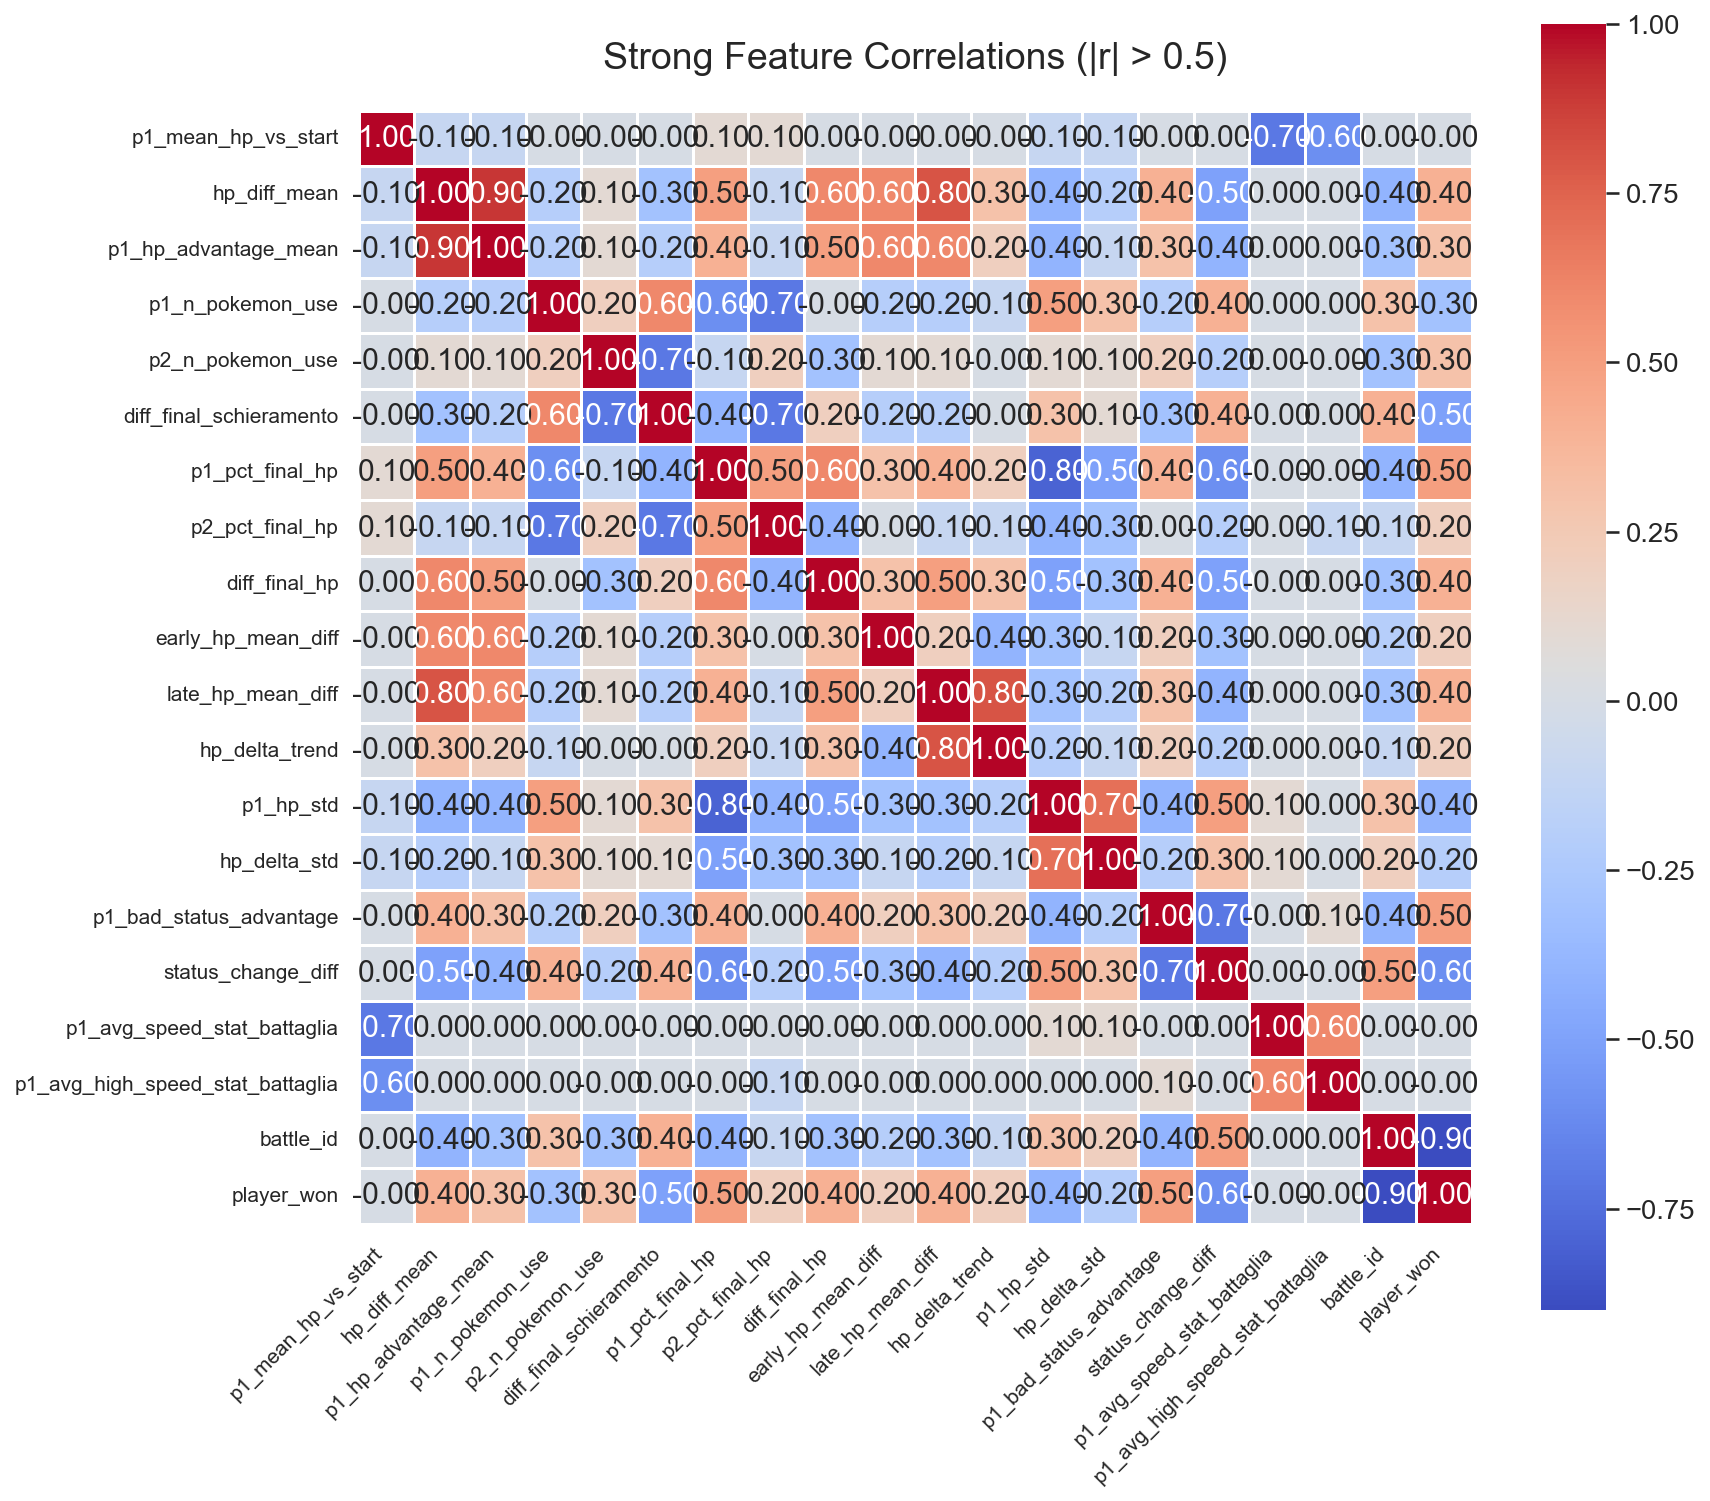

In [35]:
train_df_scaled.describe()
corr_matrix = train_df_scaled.corr(numeric_only=True).round(1)
print(corr_matrix.shape)
pd.set_option('display.max_columns', None)   # mostra tutte le colonne
pd.set_option('display.max_rows', None)      # mostra tutte le righe
pd.set_option('display.width', 0)            # evita line wrapping
pd.set_option('display.max_colwidth', None)  # mostra nomi completi delle colonne


#attenzione mostra solo colonne tanto correlate nel dataset
# 1️⃣ Compute correlation matrix and filter strong correlations
mask_strong = (corr_matrix.abs() > 0.5) & (corr_matrix.abs() < 1.0)
strong_features = corr_matrix.columns[mask_strong.any()].tolist()
subset_corr = corr_matrix.loc[strong_features, strong_features]

# 2️⃣ Dynamically adjust figure size based on number of features
n = len(subset_corr.columns)
fig_width = max(12, n * 0.6)
fig_height = max(10, n * 0.6)

# 3️⃣ Plot with larger figure, higher DPI, and better layout
plt.figure(figsize=(fig_width, fig_height), dpi=150)
sns.heatmap(
    subset_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,        # small grid lines for separation
    cbar_kws={'shrink': 0.8}
)

plt.title("Strong Feature Correlations (|r| > 0.5)", fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


In [36]:
#working with standardize we give more weight to variable that have absolute value in start smaller than other, example diff variable
# Define features and target
features = [col for col in train_df_scaled.columns if col not in ['battle_id', 'player_won']]
X = train_df_scaled[features]
print(X.shape)
y = train_df_scaled['player_won']

(10000, 27)


### STUDIAMO GRAFICAMENTE FEATURES E OUTPUT E TRA FEATURE

player_won
1    5000
0    5000
Name: count, dtype: int64


c:\Users\sacco\Desktop\Uni\1-1\FDS\challenge\clone\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\sacco\Desktop\Uni\1-1\FDS\challenge\clone\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)


AttributeError: module 'matplotlib' has no attribute 'show'

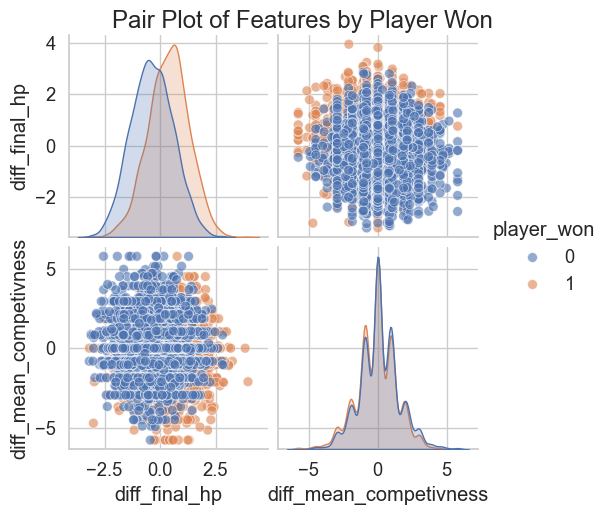

In [40]:
print(train_df['player_won'].value_counts())#victory classes ar perfectly balance
#best case for accuracy calcolation 
#show_graph(train_df_scaled[['p1_mean_competivness','battle_id']],train_df_scaled[['player_won']])
show_graph(train_df_scaled[['diff_final_hp','diff_mean_competivness']],train_df_scaled[['player_won']])

Index(['p1_mean_hp', 'p1_mean_spe', 'p1_mean_atk', 'p1_mean_def', 'p1_mean_sp',
       'diff_hp', 'diff_spe', 'diff_atk', 'diff_def', 'diff_sp',
       'hp_diff_mean', 'p1_hp_advantage_mean', 'p1_n_pokemon_use',
       'p2_n_pokemon_use', 'diff_final_schieramento', 'p1_pct_final_hp',
       'p2_pct_final_hp', 'diff_final_hp', 'early_hp_mean_diff',
       'late_hp_mean_diff', 'hp_delta_trend', 'p1_hp_std', 'p2_hp_std',
       'hp_delta_std', 'p1_bad_status_advantage', 'status_change_diff',
       'p1_type_diversity', 'p1_avg_speed_stat_battaglia',
       'p1_avg_high_speed_stat_battaglia', 'battle_id', 'player_won'],
      dtype='object')


c:\Users\sacco\Desktop\Uni\1-1\FDS\challenge\clone\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\sacco\Desktop\Uni\1-1\FDS\challenge\clone\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)


AttributeError: module 'matplotlib' has no attribute 'show'

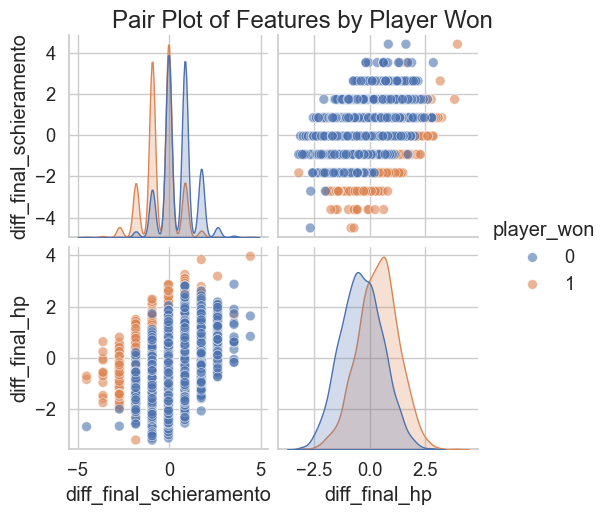

In [ ]:
print(train_df_scaled.columns)
#si cominciano ad intravedere effettive distribuzioni bivariate con eterogeneita tra gruppi di vincita e perdita
show_graph(train_df_scaled[['diff_final_schieramento','diff_final_hp']],train_df_scaled[['player_won']])

### PolynomialFeatures 
crea nuove feature come potenze e relazioni tra le feature numeriche originali, per vedere relazioni non lineari; il modello cattura curvature e relazioni mantenendo la linearità nei parametri => purtroppo aggiunge $\binom{n+d}{n}$ feature (n=numero feature originali e d=degree=2 o altro intero) e aumenta il tempo di addestramento => valuta se usare una PCA per gestire l'esplosione dimensionale.

Usalo solo se le feature originali sono informative

### TRAIN AND SUBMIT

In [ ]:
"""
# Initialize and train the model
print("Training a simple Logistic Regression model...")
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)
print("Model training complete.")

# Evaluate on validation set
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# PCA?
USE_PCA = False
POLY_ENABLED = False# se enabled 77.64% (+/- 0.69%) altrimenti 77.94% (+/- 0.35%)

steps = []
if POLY_ENABLED:
    steps.append(("poly", PolynomialFeatures(degree=2, include_bias=False)))
#standardizza
steps.append(("scaler", StandardScaler()))
if USE_PCA:
    steps.append(("pca", PCA(n_components=0.95, svd_solver="full")))  # ~95% varianza

steps.append(("logreg", LogisticRegression(max_iter=2000, random_state=42)))

pipe = Pipeline(steps)

#kfold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV
print("Training Logistic Regression con 5-Fold Cross-Validation...\n")
scores = cross_val_score(pipe, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
print(f"Cross-validation accuracies: {np.round(scores, 4)}")
print(f"Mean CV accuracy: {np.mean(scores)*100:.2f}% (+/- {np.std(scores)*100:.2f}%)")

#Training finale
pipe.fit(X, y)
print("\nFinal model trained on all training data.")
#sm.logisticModel(tran_df[feate1,feature2,feature2**2,fature1*feature2])

Training Logistic Regression con 5-Fold Cross-Validation...

Cross-validation accuracies: [0.8435 0.8265 0.8325 0.839  0.832 ]
Mean CV accuracy: 83.47% (+/- 0.59%)

Final model trained on all training data.


### SUBMIT

In [ ]:
# Make predictions on the real test data
X_test = test_df[features]
print("Generating predictions on the test set...")
test_predictions = pipe.predict(X_test)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})

# Save submission CSV
submission_df.to_csv('submission.csv', index=False)
print("\n'submission.csv' file created successfully!")
display(submission_df.head())

KeyError: "['p1_mean_competivness', 'p1_mean_hp_vs_start', 'p1_mean_start_vs_speed', 'p1_mean_atk_vs_def', 'diff_mean_competivness', 'diff_mean_hp_vs_start', 'diff_mean_start_vs_speed', 'diff_mean_atk_vs_def'] not in index"